# **Unsupervised ML Model for Customer Segregation (into 3 clusters) based on customer buying behavior and demographics**

### **Source of dataset:** 
KPMG Virtual Internship @ theforage.com

### **Description of dataset:** 
Dataset used in this exercise were obtained from 'customer.csv' and 'transaction.csv' (after minor manual cleaning in using excel filtering functions). These files are housed @ theforage.com under the KPMG virtual internship option [1]. 
Customer dataset contains customer demographics, while transaction dataset contains the past 3 months' transaction in the store. The two datasets were merged on 'customer_id' to create the final training dataset used in this exercise. 

In [ ]:
!pip install kmodes -qq > /dev/null
!pip install --upgrade kmodes -qq > /dev/null
!pip install sweetviz -qq > /dev/null

!pip install kprototypes -qq > /dev/null
!pip install pyspark -qq > /dev/null
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz 
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, minmax_scale, LabelEncoder

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [ ]:
#file1 = '/content/customer2.csv'
file1 = '/content/customer3.csv'
file2 = '/content/transaction2.csv'
customer =  pd.read_csv(file1)
transaction = pd.read_csv(file2)

# **1. EDA**
## 1.1. Inspect and Prepare Dataset for Analysis

In [ ]:
df1 = customer.copy()
customer.isna().sum()

customer_id                              0
first_name                               0
last_name                              125
gender                                   0
past_3_years_bike_related_purchases      0
age                                      0
wealth_segment                           0
owns_car                                 0
tenure                                  87
postcode                                 0
state                                    0
property_valuation                       0
dtype: int64

In [ ]:
transaction.isna().sum()

transaction_id      0
customer_id         0
product_line      197
product_class     197
product_size      197
list_price          0
standard_cost     197
dtype: int64

In [ ]:
transaction['gross_profit']= transaction.list_price - transaction.standard_cost.fillna(0)
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  20000 non-null  int64  
 1   customer_id     20000 non-null  int64  
 2   product_line    19803 non-null  object 
 3   product_class   19803 non-null  object 
 4   product_size    19803 non-null  object 
 5   list_price      20000 non-null  float64
 6   standard_cost   19803 non-null  float64
 7   gross_profit    20000 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 1.2+ MB


In [ ]:
df2 = transaction.groupby('customer_id').agg({'gross_profit':'sum'}).reset_index()
print(df2.info())
df2.tail(15).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3494 entries, 0 to 3493
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customer_id   3494 non-null   int64  
 1   gross_profit  3494 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 54.7 KB
None


,3479,3480,3481,3482,3483,3484,3485,3486,3487,3488,3489,3490,3491,3492,3493
customer_id,3487.00,3488.00,3489.00,3490.00,3491.00,3492.00,3493.00,3494.00,3495.00,3496.00,3497.00,3498.00,3499.00,3500.00,5034.00
gross_profit,1837.75,815.95,2644.44,2379.57,1430.28,2193.81,3728.88,2755.11,3847.65,2045.84,1648.32,3147.33,4955.25,1785.86,269.48


In [ ]:
# merge and reset index
df = df1.merge(df2, how='left', on='customer_id').reset_index()

In [ ]:
df.info() # final dataset to work with

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994 entries, 0 to 3993
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   index                                3994 non-null   int64  
 1   customer_id                          3994 non-null   int64  
 2   first_name                           3994 non-null   object 
 3   last_name                            3869 non-null   object 
 4   gender                               3994 non-null   object 
 5   past_3_years_bike_related_purchases  3994 non-null   int64  
 6   age                                  3994 non-null   int64  
 7   wealth_segment                       3994 non-null   object 
 8   owns_car                             3994 non-null   object 
 9   tenure                               3907 non-null   float64
 10  postcode                             3994 non-null   int64  
 11  state                         

In [ ]:
#cross-check
[print(i) for i in df2.customer_id if i not in df1.customer_id]

# in df1:
## customer_id 3, 10, 22, 23 are filtered out because of incomplete raw data
## customer_id 753 and 3790 are deceased customer, so was filtered out

# in df2: 
## customer_id 3790 is not present, but have extra customer_id 5034

# overall, 6 gross_profit data in df2 has no matching customer_id on df1 (not 7)

5034


[None]

## 1.2. AutoEDA Summary Using SweetViz

                                             |          | [  0%]   00:00 -> (? left)


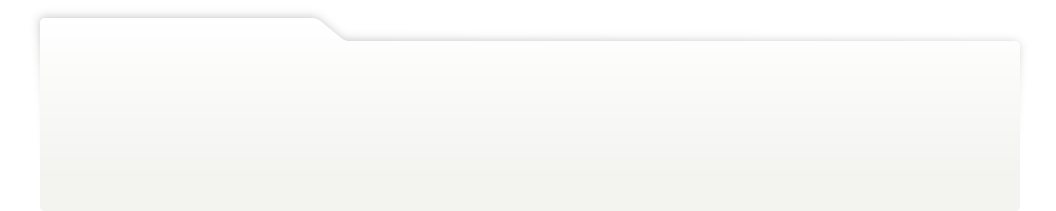
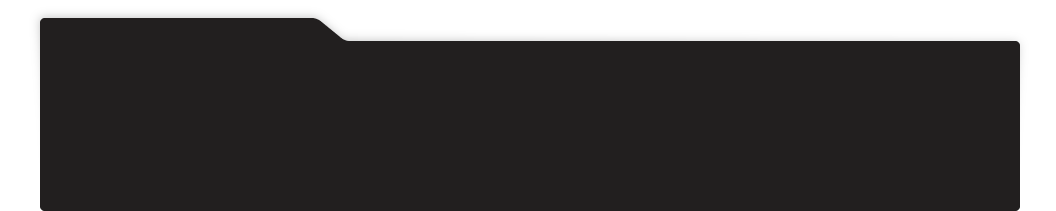
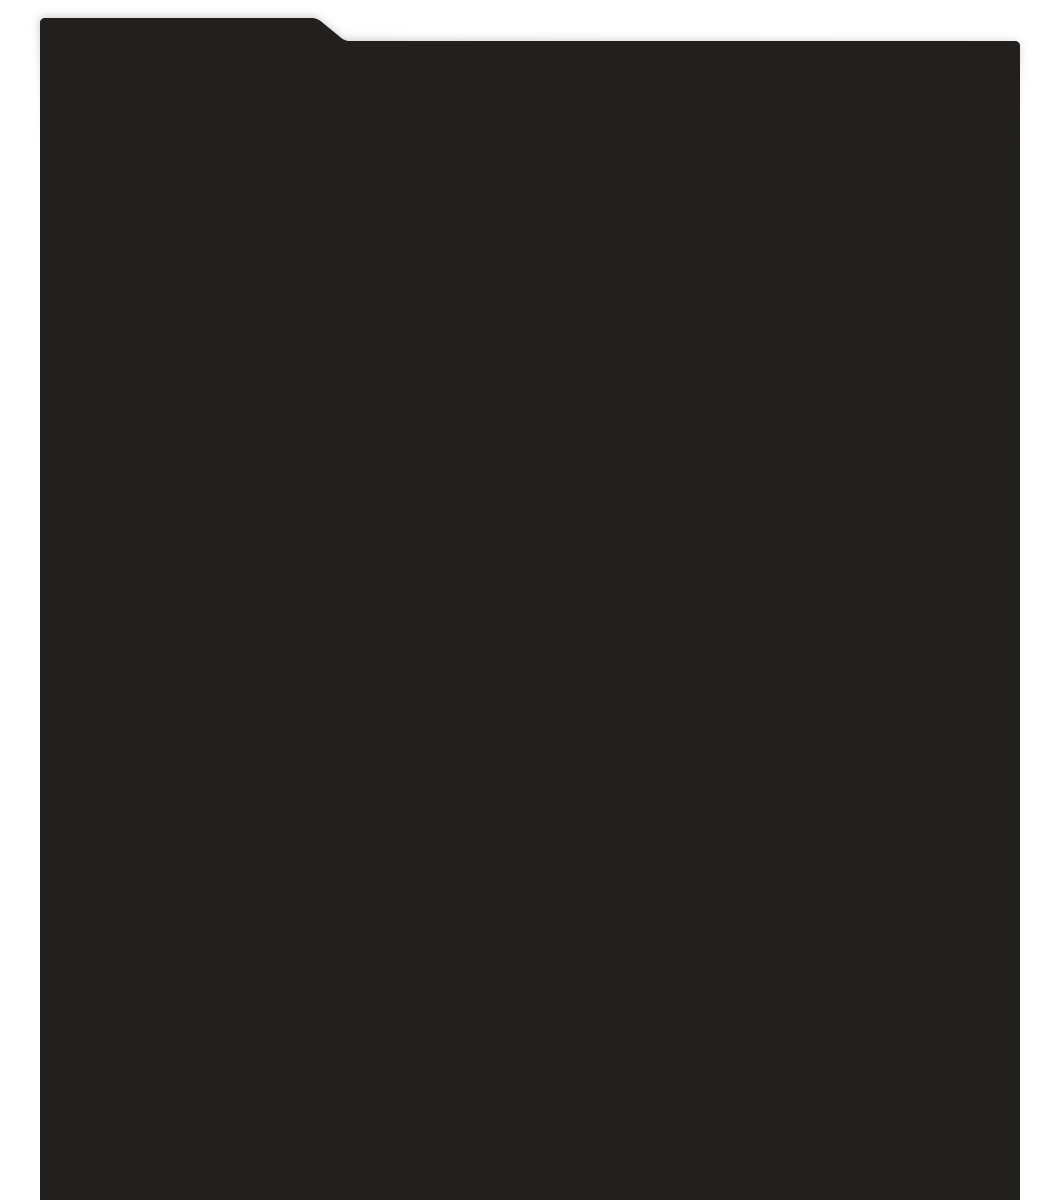
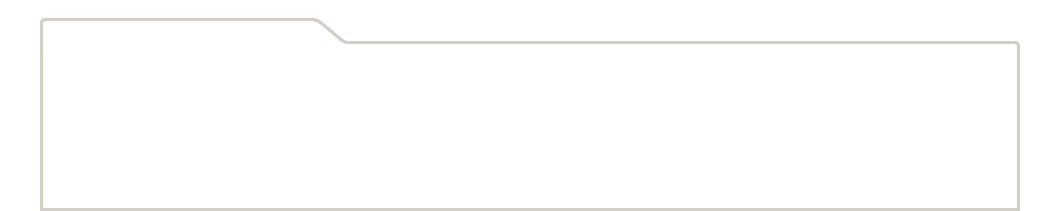
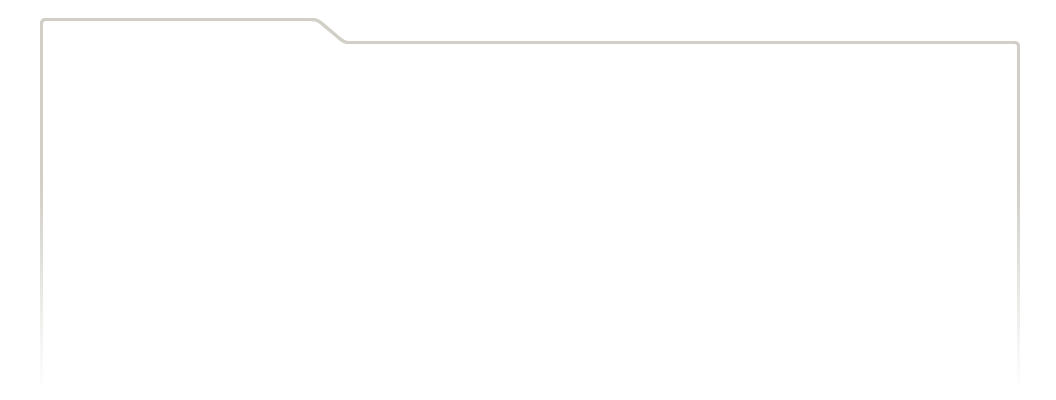
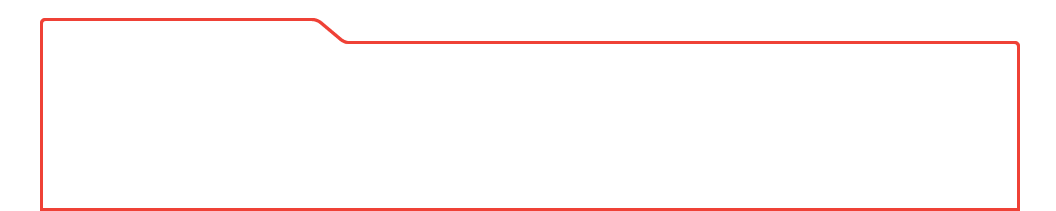
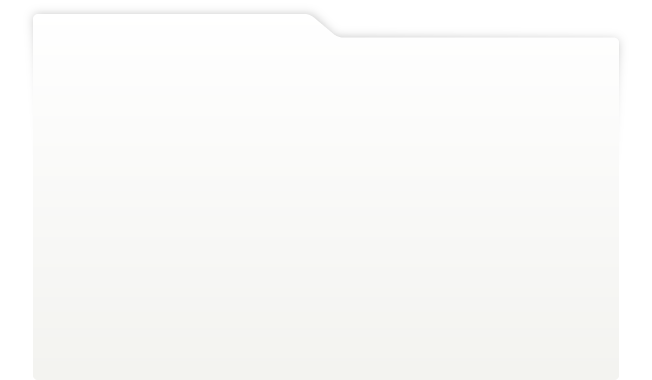
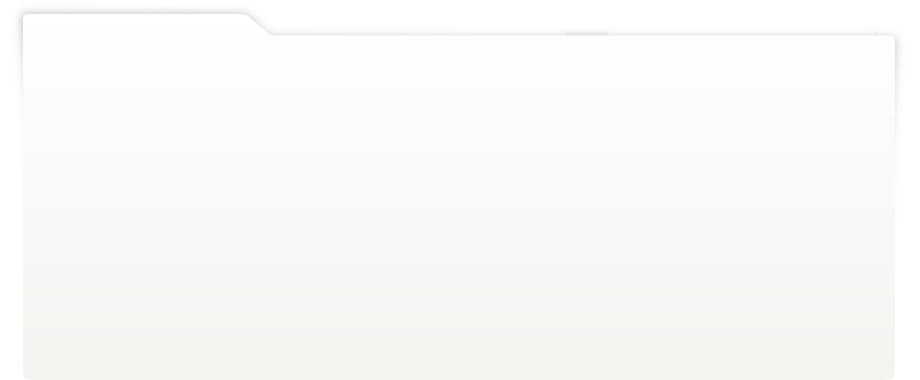
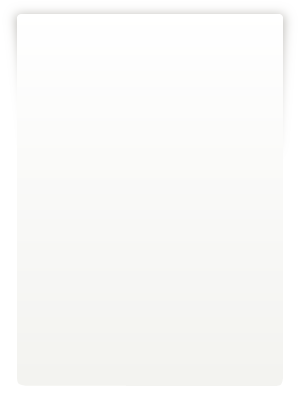
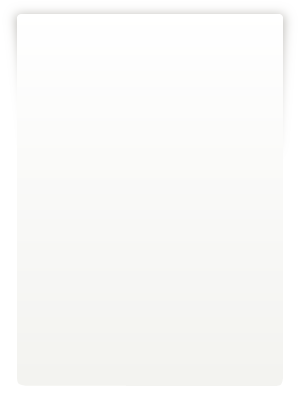
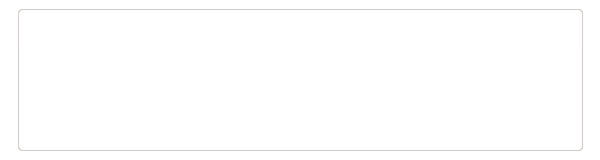
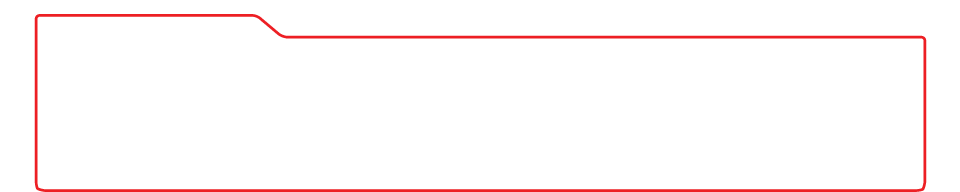
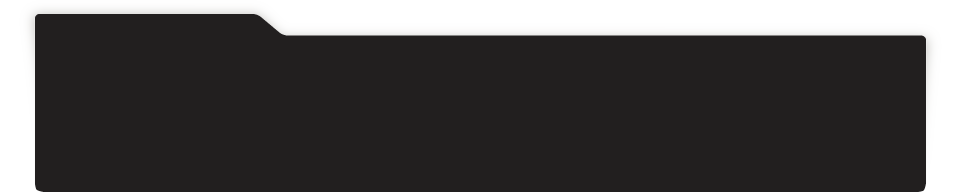
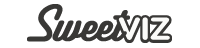
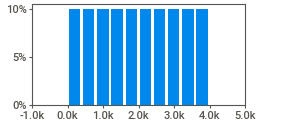
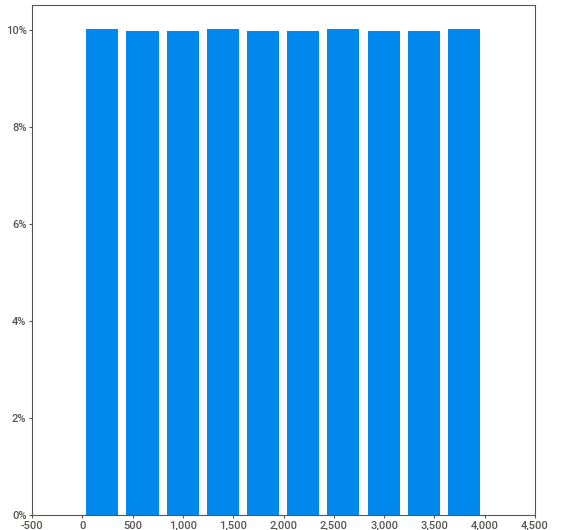
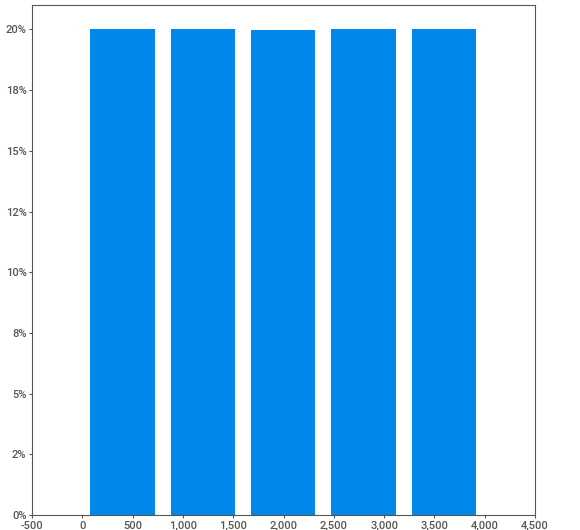
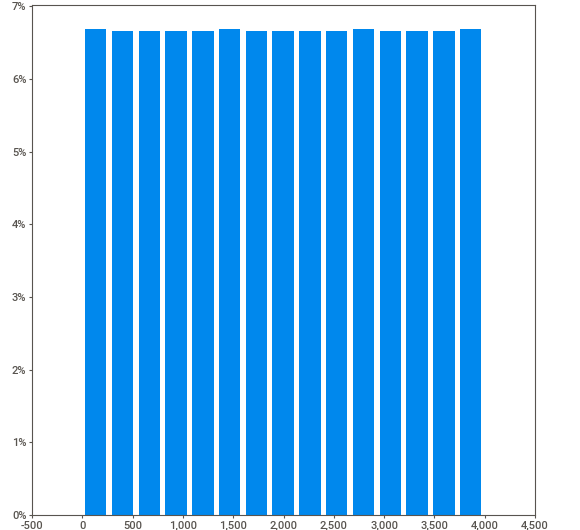
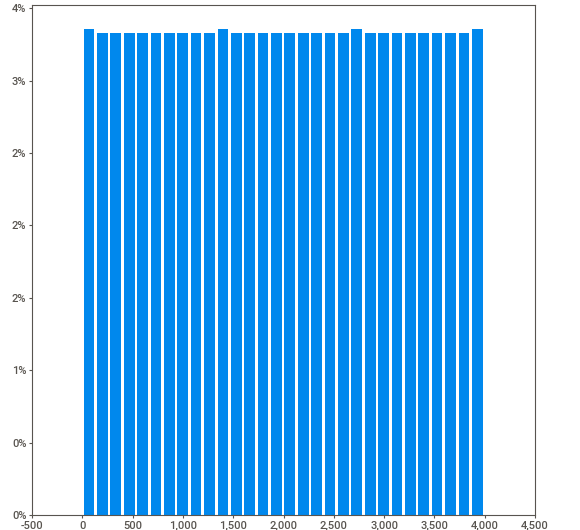
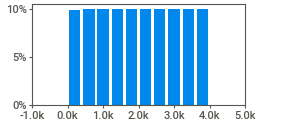
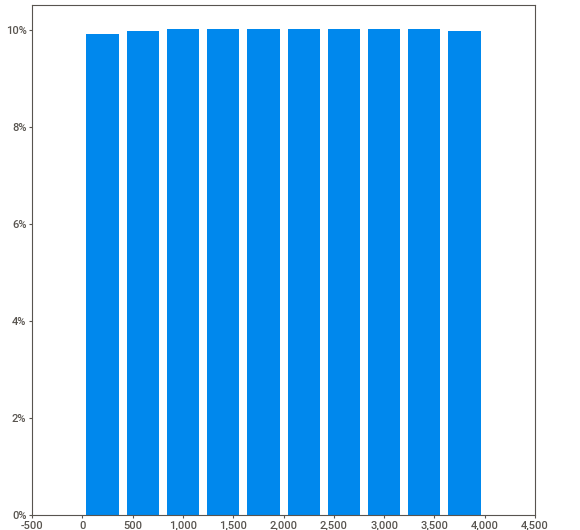
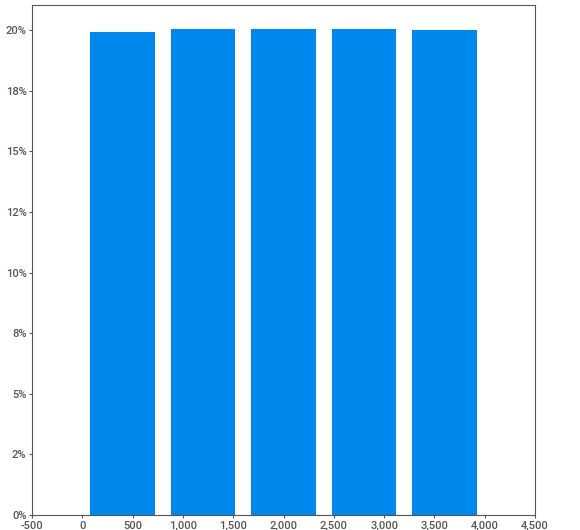
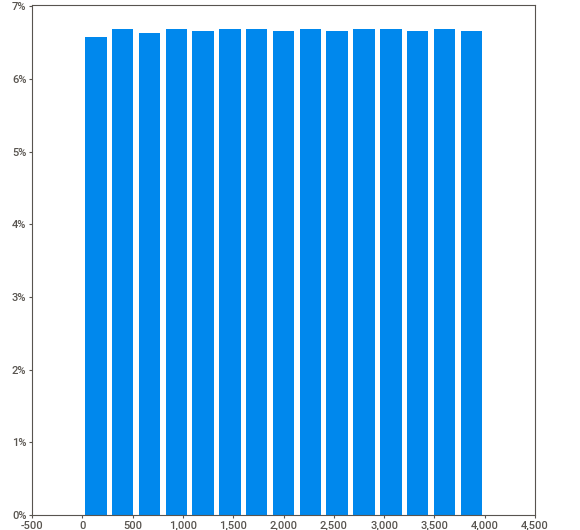
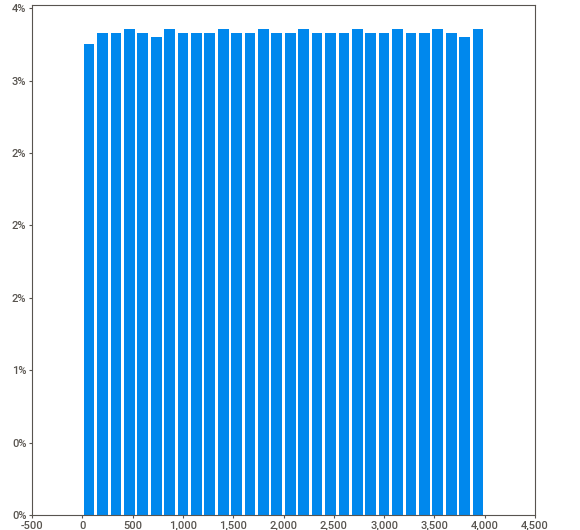
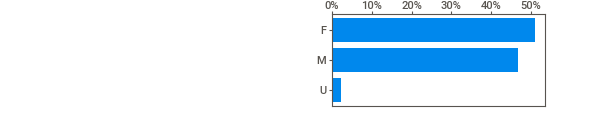
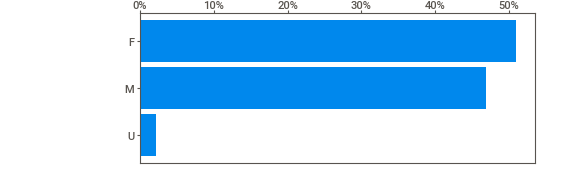
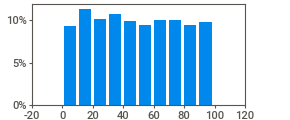
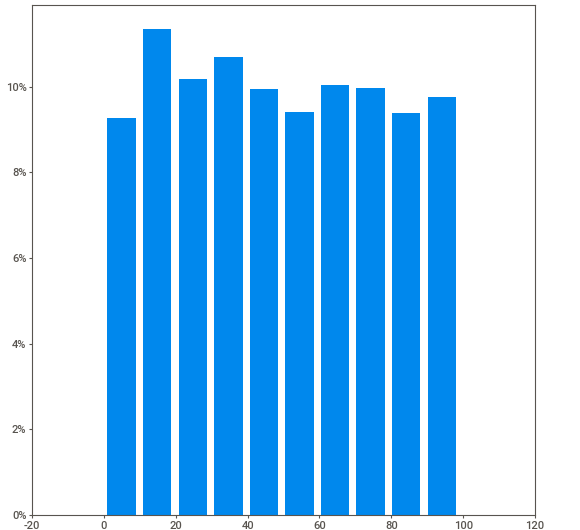
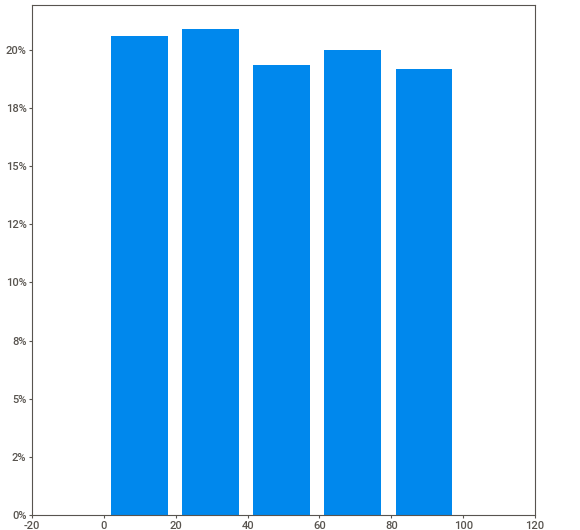
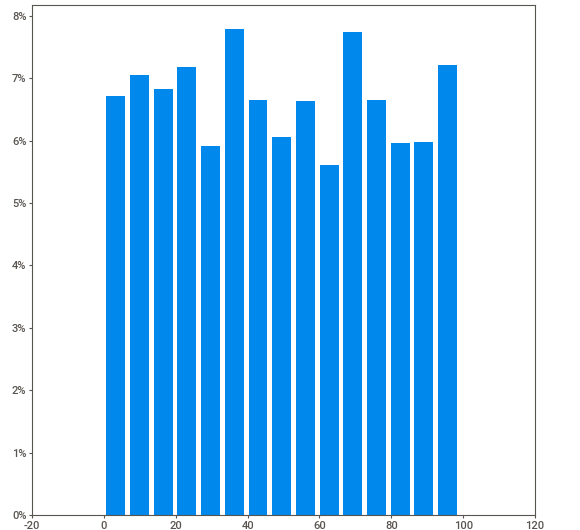
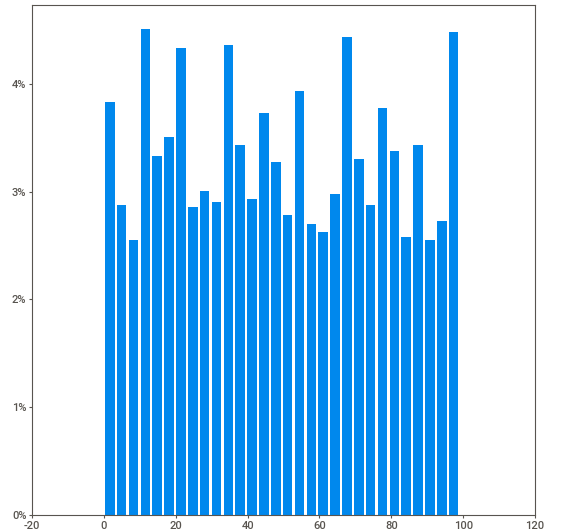
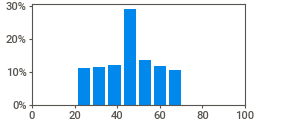
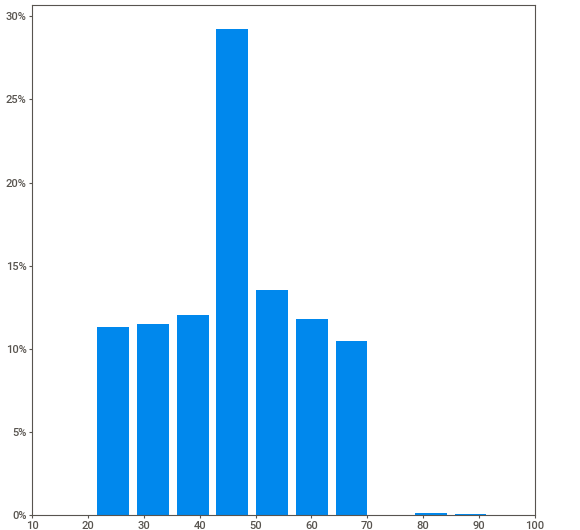
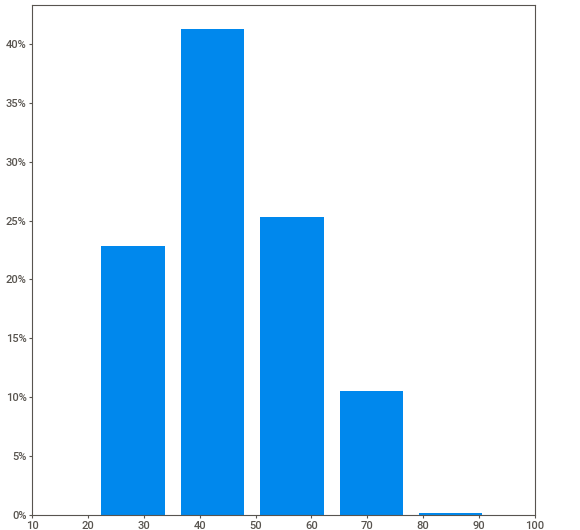
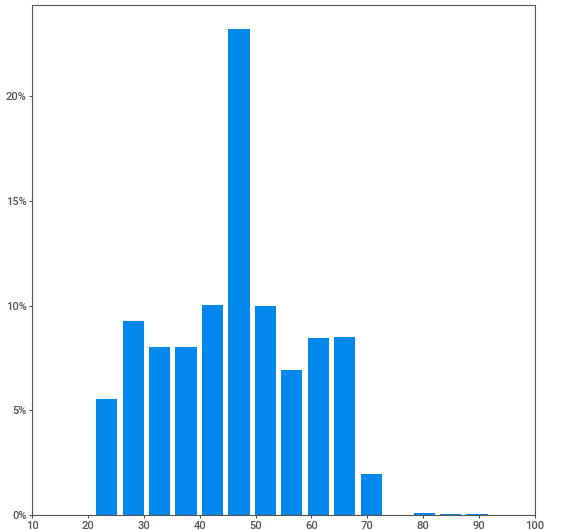
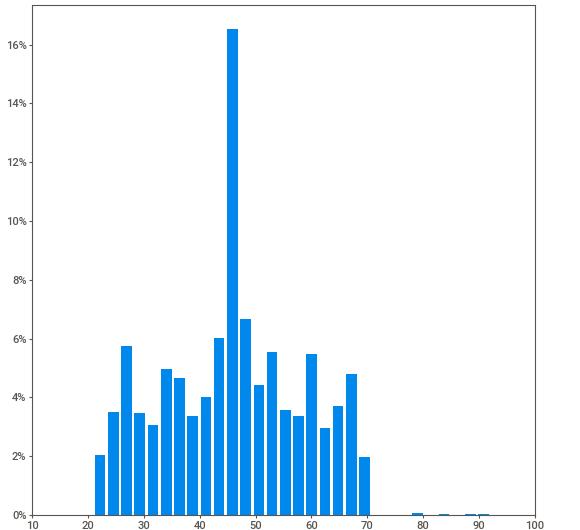
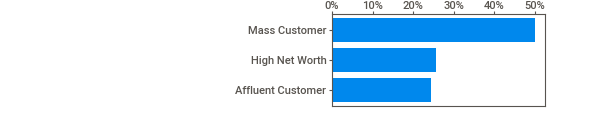
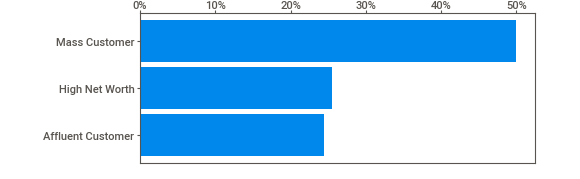
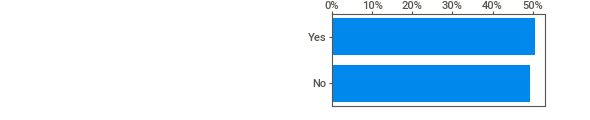
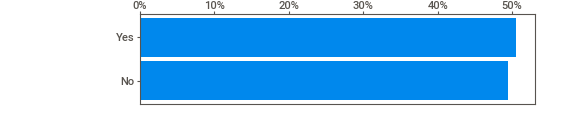
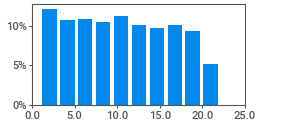
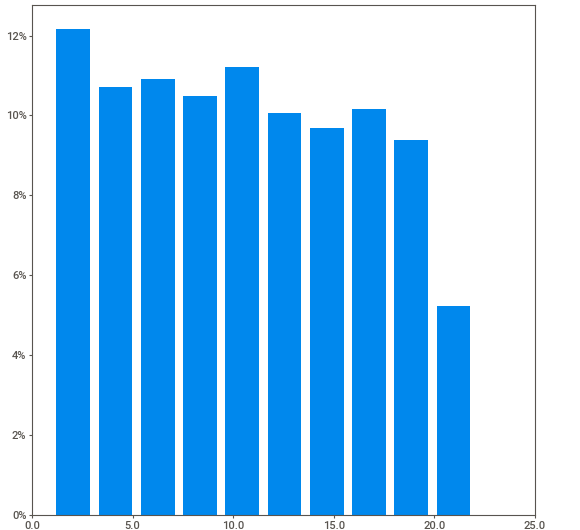
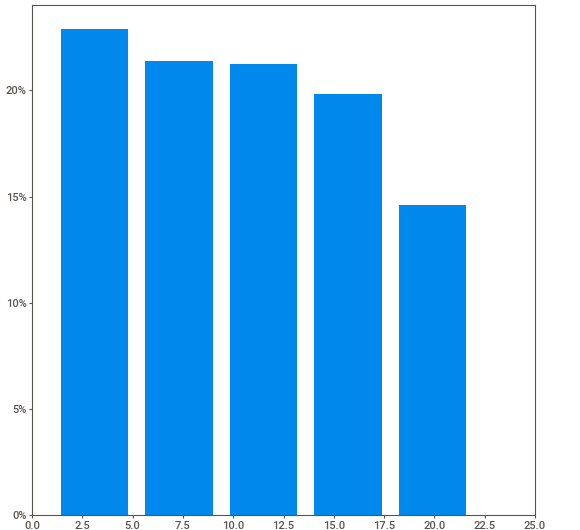
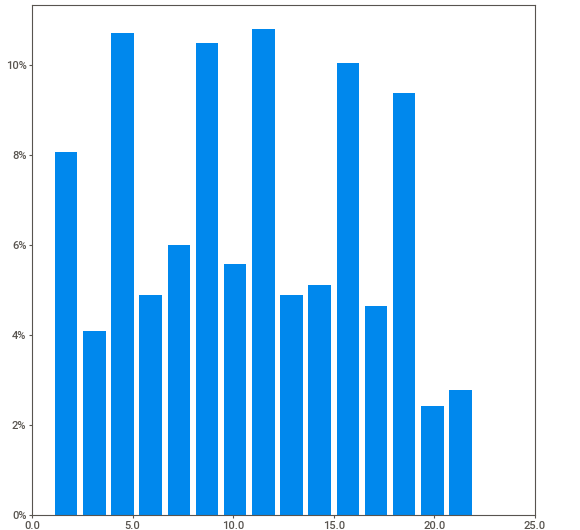
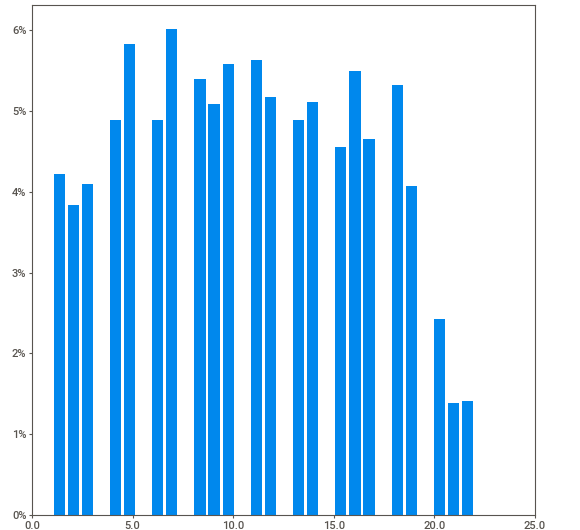
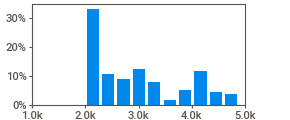
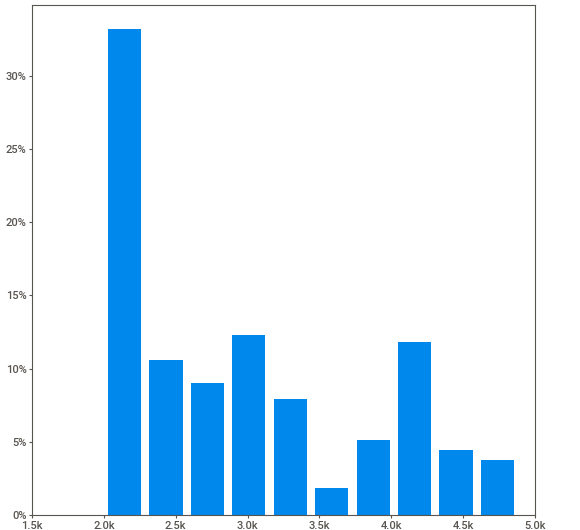
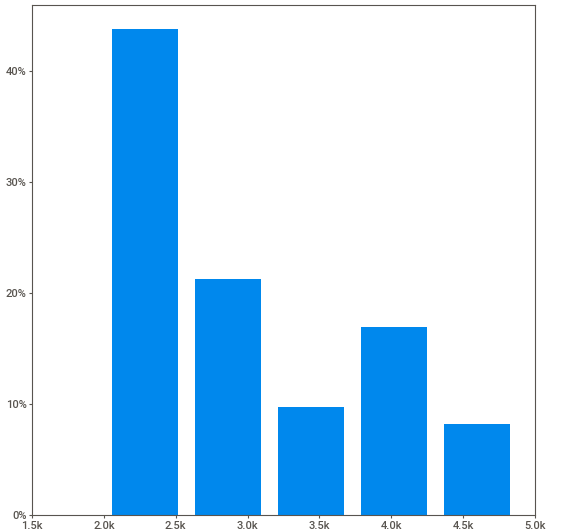
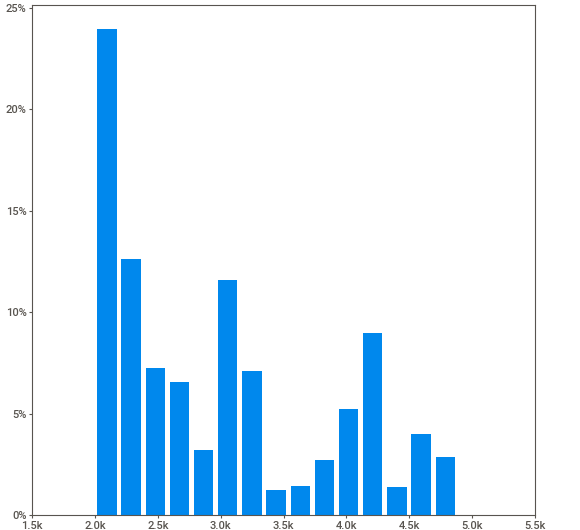
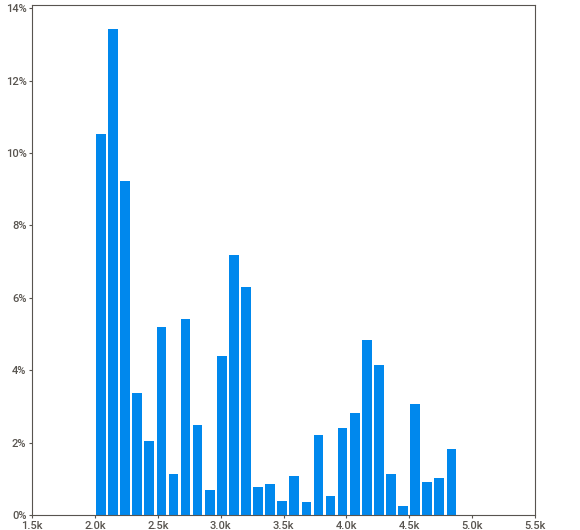
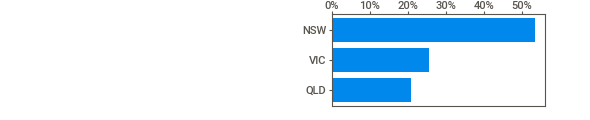
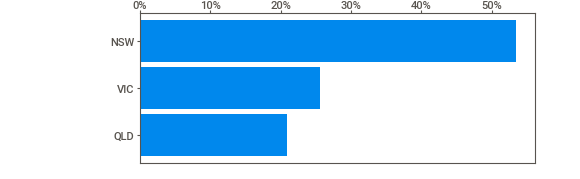
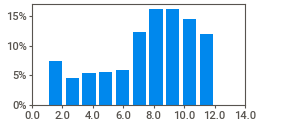
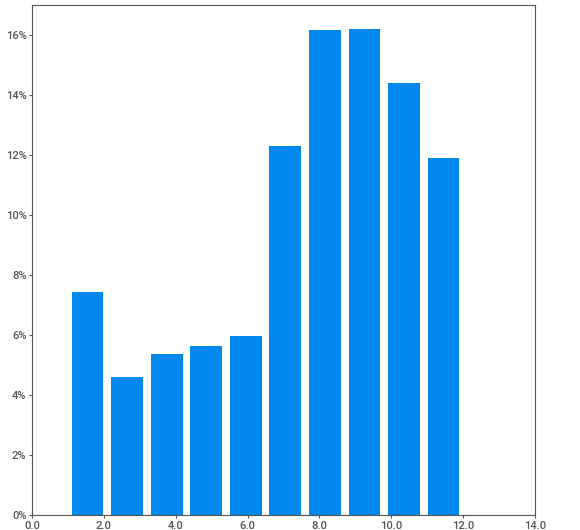
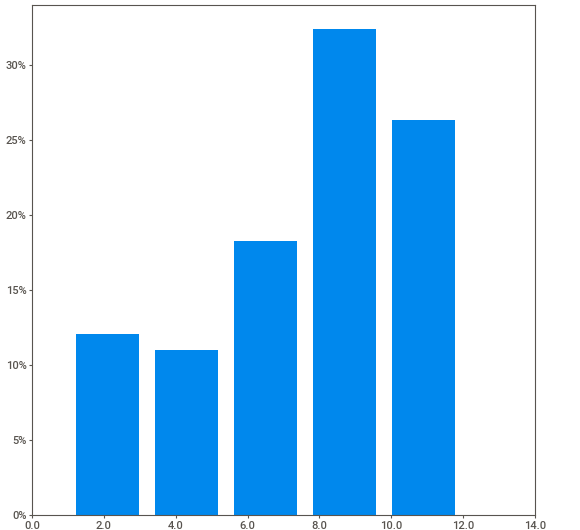
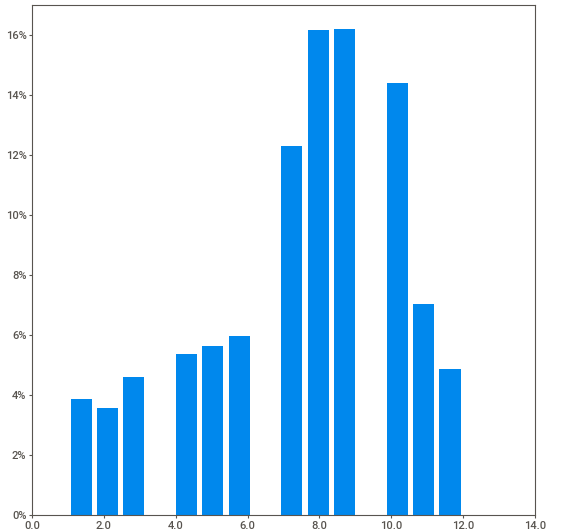
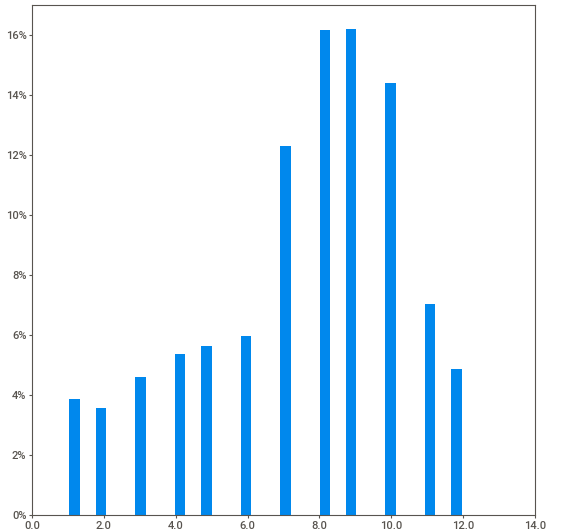
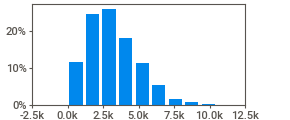
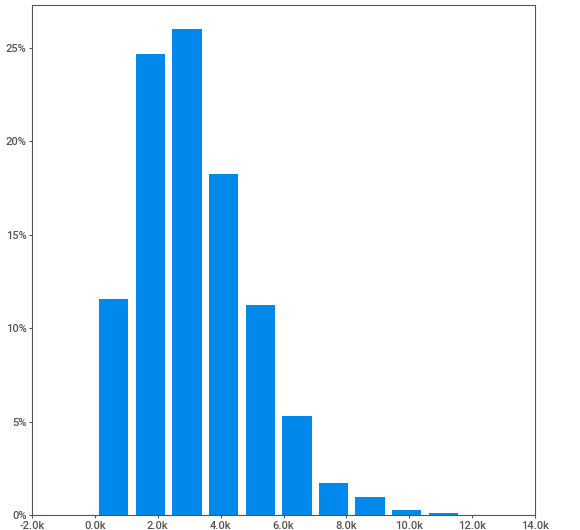
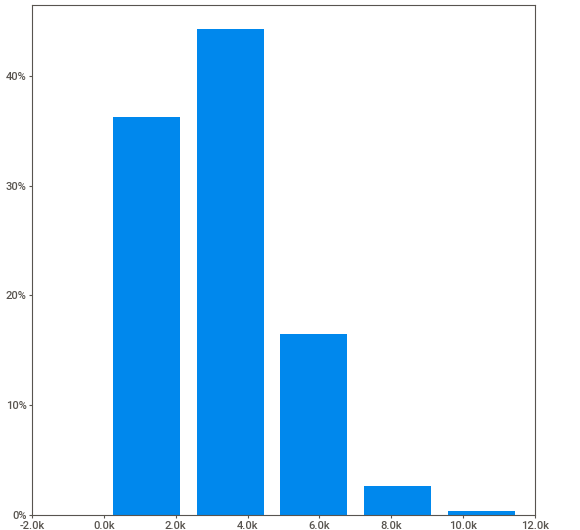
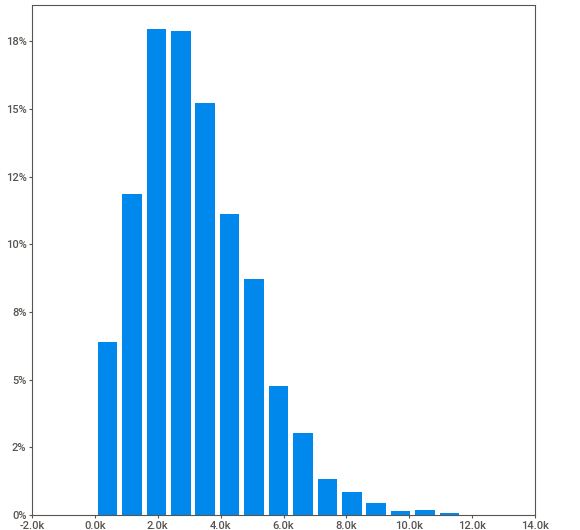
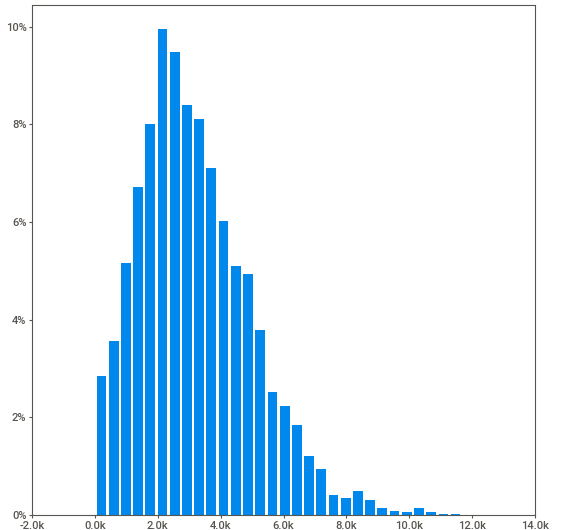
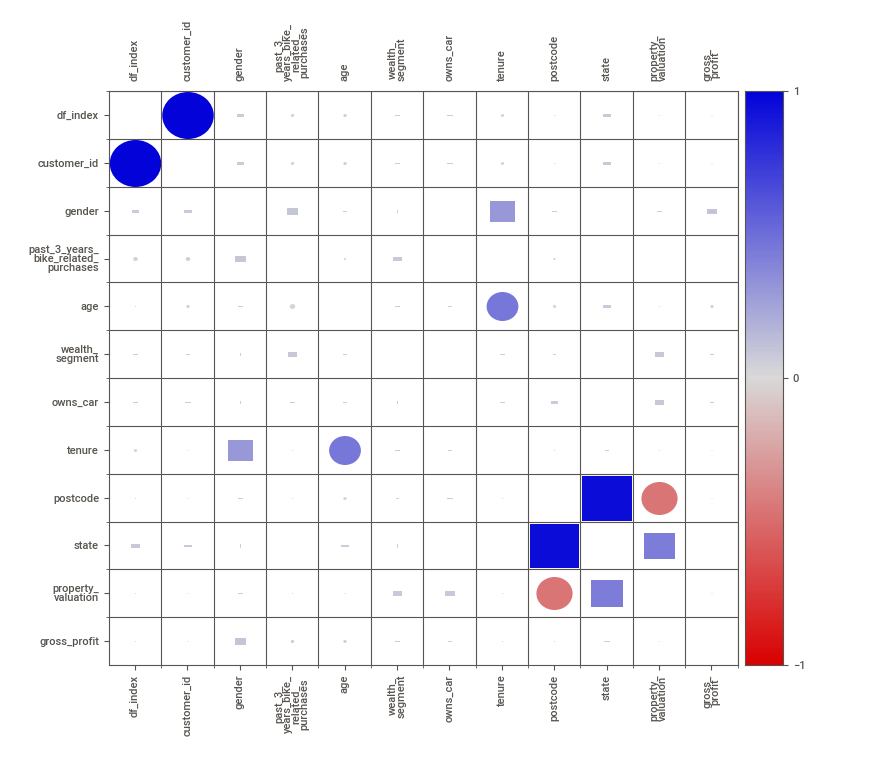
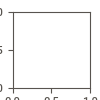

In [ ]:
autoEDA = sweetviz.analyze(df)
autoEDA.show_notebook()

In [ ]:
# assign 0 to gross_profit for customers with no recent 3 mth's purchase
df.gross_profit = df.gross_profit.fillna(0)

## 1.3 Scale and Encode Cleaned Feature Dataset

In [ ]:
# drop columns with no predictive power from feature matrix
# split feature matrix into categorical (X2 - for onehot encoding) and numerical (X1 - for scaling)
X1 = df.drop(['index','customer_id','first_name','last_name','postcode','gender','wealth_segment', 'owns_car', 'state'], axis=1)
col_name = X1.columns
col_name

Index(['past_3_years_bike_related_purchases', 'age', 'tenure',
       'property_valuation', 'gross_profit'],
      dtype='object')

In [ ]:
X2 = df.drop(['index','customer_id','first_name','last_name','postcode','past_3_years_bike_related_purchases','age','tenure', 'property_valuation', 'gross_profit'],axis=1).astype('category')
X2.columns

Index(['gender', 'wealth_segment', 'owns_car', 'state'], dtype='object')

In [ ]:
scaler = StandardScaler(with_mean=True, with_std=True)
X1 = pd.DataFrame(scaler.fit_transform(X1)).fillna(0)
X1.columns = col_name
X1.head()

,past_3_years_bike_related_purchases,age,tenure,property_valuation,gross_profit
0,1.537066,1.929604,0.060520,0.879515,0.118426
1,1.119177,-0.233505,0.944114,0.879515,-0.281108
2,-0.552382,1.288682,-0.646356,0.525404,-1.293121
3,0.248573,0.006840,-0.469637,-1.245152,-0.195997
4,-0.482734,0.888107,0.413957,0.525404,0.586899


In [ ]:
X2 = pd.get_dummies(X2, drop_first=False).astype('int')
X2.head()

,gender_F,gender_M,gender_U,wealth_segment_Affluent Customer,wealth_segment_High Net Worth,wealth_segment_Mass Customer,owns_car_No,owns_car_Yes,state_NSW,state_QLD,state_VIC
0,1,0,0,0,0,1,0,1,1,0,0
1,0,1,0,0,0,1,0,1,1,0,0
2,0,1,0,0,0,1,1,0,0,1,0
3,1,0,0,1,0,0,0,1,1,0,0
4,0,1,0,0,1,0,0,1,0,0,1


In [ ]:
# # combine numerical and OHE categorical features
X = pd.concat([X1,X2],axis=1,ignore_index=0) #df.customer_id,

X.info()
X.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994 entries, 0 to 3993
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   past_3_years_bike_related_purchases  3994 non-null   float64
 1   age                                  3994 non-null   float64
 2   tenure                               3994 non-null   float64
 3   property_valuation                   3994 non-null   float64
 4   gross_profit                         3994 non-null   float64
 5   gender_F                             3994 non-null   int64  
 6   gender_M                             3994 non-null   int64  
 7   gender_U                             3994 non-null   int64  
 8   wealth_segment_Affluent Customer     3994 non-null   int64  
 9   wealth_segment_High Net Worth        3994 non-null   int64  
 10  wealth_segment_Mass Customer         3994 non-null   int64  
 11  owns_car_No                   

,0,1,2,3,4
past_3_years_bike_related_purchases,1.537066,1.119177,-0.552382,0.248573,-0.482734
age,1.929604,-0.233505,1.288682,0.006840,0.888107
tenure,0.060520,0.944114,-0.646356,-0.469637,0.413957
property_valuation,0.879515,0.879515,0.525404,-1.245152,0.525404
gross_profit,0.118426,-0.281108,-1.293121,-0.195997,0.586899
gender_F,1.000000,0.000000,0.000000,1.000000,0.000000
gender_M,0.000000,1.000000,1.000000,0.000000,1.000000
gender_U,0.000000,0.000000,0.000000,0.000000,0.000000
wealth_segment_Affluent Customer,0.000000,0.000000,0.000000,1.000000,0.000000
wealth_segment_High Net Worth,0.000000,0.000000,0.000000,0.000000,1.000000


## 1.4. Check Inertia (Sum of Squared Distance to Centroid within clusters) vs. Cluster numbers

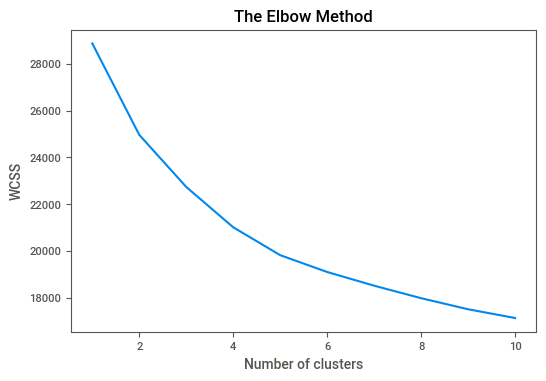

In [ ]:
import warnings
warnings.filterwarnings('ignore')

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', 
                random_state = 4321)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# __2. Train Unsupervised Clustering Model__

## 2.1. KMeans Model - strictly for numerical features

In [ ]:
# suggested clusters from elbow methods ~4, but we're interested to cluster customers into 3 different profiles (high, med, low)
kme = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=4321) 
Kmeans_cluster_label = kme.fit_predict(X)  

## 2.2. KModes and KPrototypes Models - for mixed numerical with categorical features (accept categorical features without OHE)

Kmodes use feature "differences" instead of "euclidean distance" to generate clusters. 
Kproto is a mixed between Kmeans and Kmodes, need to specify categorical features not, otherwise essentially becomes Kmeans.

In [ ]:
km = KModes(n_clusters=3, init='Huang', n_init=10, random_state=4321, verbose=0)
kp = KPrototypes(n_clusters=3, init='Huang', n_init=10, random_state=4321, verbose=0) #n_init='auto', init='Cao'

In [ ]:
Kmodes_cluster_label = km.fit_predict(X)
Kproto_cluster_label = kp.fit_predict(X, categorical=[5,6,7,8,9,10,11])

## 2.3. DBSCAN Models

In [ ]:
dbsm = DBSCAN() # dbscan doesn't allow to set n_cluster
dbsm.fit(X)
DBScan_cluster_label = dbsm.fit_predict(X)

## 2.4. Summarize Clustering Results & Metrics

In [ ]:
Cluster = pd.DataFrame()
Cluster['kmeans_label'] = pd.DataFrame(Kmeans_cluster_label)
Cluster['kproto_label'] = pd.DataFrame(Kproto_cluster_label)
Cluster['kmodes_label'] = pd.DataFrame(Kmodes_cluster_label)
Cluster['DBScan_label'] = pd.DataFrame(DBScan_cluster_label)

In [ ]:
result = pd.concat([df,Cluster],axis=1,ignore_index=False)

In [ ]:
result.to_csv('/content/result3k.csv')

In [ ]:
# Calculate Silhouette metrics (scoring between -1 to 1)
# 0 is no clustering, 1 is ideal (dense and nicely separated), > 0.5 is relatively well & dense clustering, 
#       < 0.2 unstructured clustering, <0 indicate items likely assigned to wrong clusters

print("Kmeans' Silhouette score: ", silhouette_score(X,Kmeans_cluster_label))
print("Kproto' Silhouette score: ", silhouette_score(X,Kproto_cluster_label))
print("Kmodes' Silhouette score: ", silhouette_score(X,Kmodes_cluster_label))
print("DBSCAN' Silhouette score: ", silhouette_score(X,DBScan_cluster_label))

Kmeans' Silhouette score:  0.12458482658386652
Kproto' Silhouette score:  0.12121016394131727
Kmodes' Silhouette score:  0.04114907938201035


ValueError: ignored

In [ ]:
# Calculate Davies Bouldin metrics 
# scoring starts from 0, and closer to zero indicates better clustering
# davies boulding metrics measure similarity of datapoints within clusters

print("Kmeans' Davies Bouldin score: ", davies_bouldin_score(X,Kmeans_cluster_label))
print("Kproto' Davies Bouldin score: ", davies_bouldin_score(X,Kproto_cluster_label))
print("Kmodes' Davies Bouldin score: ", davies_bouldin_score(X,Kmodes_cluster_label))
print("DBSCAN' Davies Bouldin score: ", davies_bouldin_score(X,DBScan_cluster_label))

Kmeans' Davies Bouldin score:  2.289036790485295
Kproto' Davies Bouldin score:  2.3378257143540657
Kmodes' Davies Bouldin score:  3.686904550589778


ValueError: ignored

In [ ]:
# Calculate Calinski Harabasz metrics / Variance ratio criterion
# higher score indicates better separation 
# the score measures ratio of the sum of between-cluster dispersion and of within-cluster dispersion

print("Kmeans' Calinski Harabasz score: ", calinski_harabasz_score(X,Kmeans_cluster_label))
print("Kproto' Calinski Harabasz score: ", calinski_harabasz_score(X,Kproto_cluster_label))
print("Kmodes' Calinski Harabasz score: ", calinski_harabasz_score(X,Kmodes_cluster_label))
print("DBSCAN' Calinski Harabasz score: ", calinski_harabasz_score(X,DBScan_cluster_label))

Kmeans' Calinski Harabasz score:  538.800031646827
Kproto' Calinski Harabasz score:  530.7862064337594
Kmodes' Calinski Harabasz score:  183.17142497938147


ValueError: ignored

## 2.5. Visualize Clusters in 2D plot

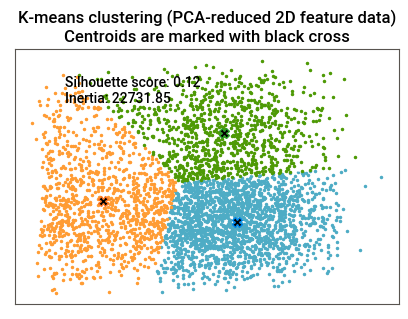

In [ ]:
# Plot Kmeans clusters by reducing into 2D datapoints (Kprototype is essentially Kmeans when categorical features are reduced)
from sklearn.decomposition import PCA

# reduce feature dimension into 2D principal axis to visualize in 2D scatterplot then retrain
reduced_X = PCA(n_components=2).fit_transform(X)

# retrain kmeans
kmeans2D = KMeans(init="k-means++", n_clusters=3, n_init=10)
kmeans2D.fit(reduced_X)
Kmeans_cluster_label = kmeans2D.fit_predict(reduced_X)
kme_sil = silhouette_score(X,Kmeans_cluster_label)

# plot figures on canvas
fig = plt.figure(figsize=(4, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
n_clusters = 3

# KMeans
k_means_cluster_centers = kmeans2D.cluster_centers_
ax = fig.add_subplot()
for k, col in zip(range(n_clusters), colors):
    my_members = Kmeans_cluster_label == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(reduced_X[my_members, 0], reduced_X[my_members, 1], "w", markerfacecolor=col, markeredgecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "X",
        markerfacecolor="k",
        markersize=7,
    )
ax.set_title("K-means clustering (PCA-reduced 2D feature data)\n"
    "Centroids are marked with black cross")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-2.2, 2, "Silhouette score: %.2f\nInertia: %.2f" % (kme_sil, kme.inertia_))
             # inertia measures the sum of squared distance to centroid within clusters

plt.show()

# __3. Analyze Clusters__

In [ ]:
result.sample(6).T

,1910,71,1506,2807,1266,3927
index,1910,71,1506,2807,1266,3927
customer_id,1916,76,1512,2813,1272,3934
first_name,Redd,Rea,Chandler,Lillian,Nettie,Cherice
last_name,O'Crowley,Hasser,NaN,Crookall,Bulfit,Wehner
gender,M,F,M,F,F,F
past_3_years_bike_related_purchases,71,20,89,51,2,38
age,28,45,44,70,38,46
wealth_segment,High Net Worth,High Net Worth,High Net Worth,Mass Customer,Affluent Customer,Mass Customer
owns_car,Yes,Yes,No,Yes,No,Yes
tenure,7.0,18.0,4.0,11.0,17.0,16.0


## 3.1. KMeans Model

kmeans_label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

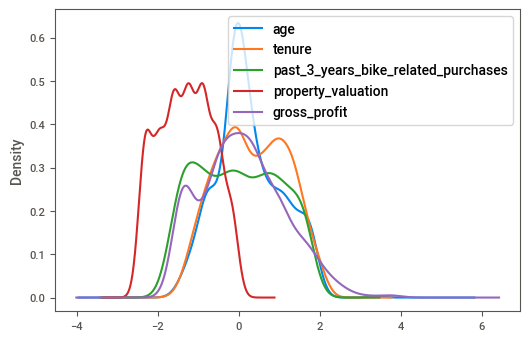

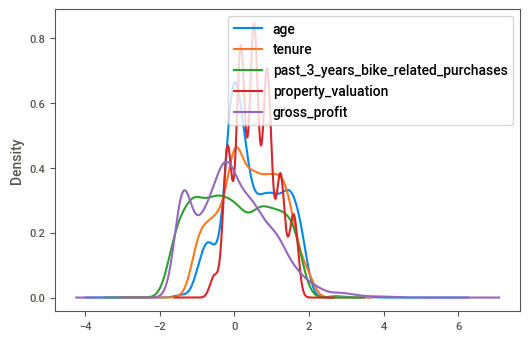

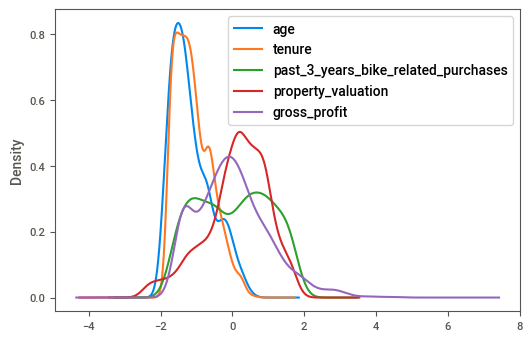

In [ ]:
# numerical vars (use scaled values for easy visualization) for kmeans model
num = pd.concat([X1,Cluster],axis=1,ignore_index=False)
num.groupby('kmeans_label')[['age','tenure','past_3_years_bike_related_purchases',
                             'property_valuation','gross_profit']].plot(kind='density')

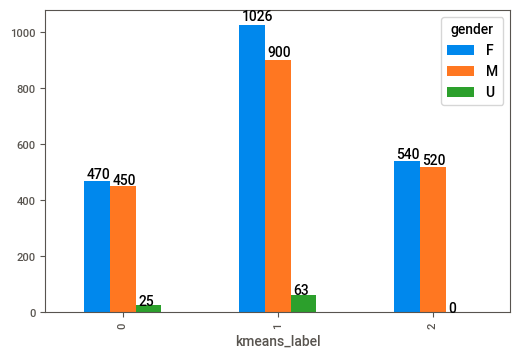

In [ ]:
# ncategorical vars
cat = df.drop(['index','customer_id','first_name','last_name','postcode','past_3_years_bike_related_purchases','age','tenure', 'property_valuation', 'gross_profit'],axis=1).astype('category')
cat = pd.concat([cat,Cluster],axis=1,ignore_index=False)

ax = cat.groupby(['gender','kmeans_label']).size().unstack('gender').plot.bar()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()*0.1, p.get_height() * 1.015))

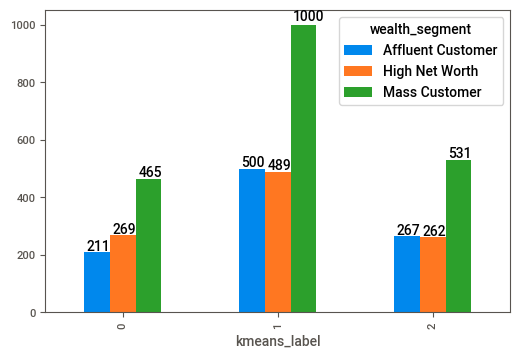

In [ ]:
ax = cat.groupby(['wealth_segment','kmeans_label']).size().unstack('wealth_segment').plot.bar()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()*0.1, p.get_height() * 1.015))

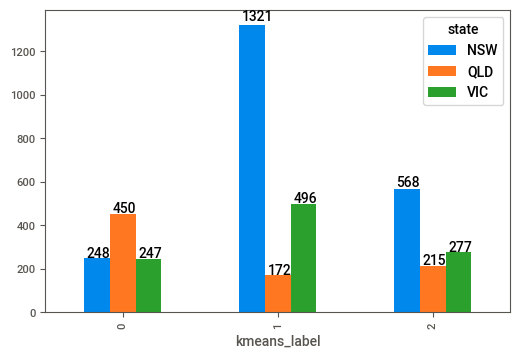

In [ ]:
ax = cat.groupby(['state','kmeans_label']).size().unstack('state').plot.bar()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()*0.1, p.get_height() * 1.015))

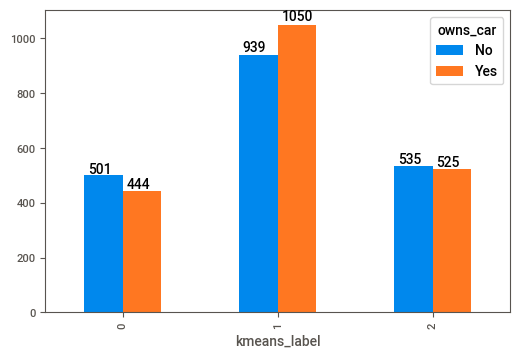

In [ ]:
ax = cat.groupby(['owns_car','kmeans_label']).size().unstack('owns_car').plot.bar()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()*0.1, p.get_height() * 1.015))

## 3.2. KPrototypes Model

kproto_label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

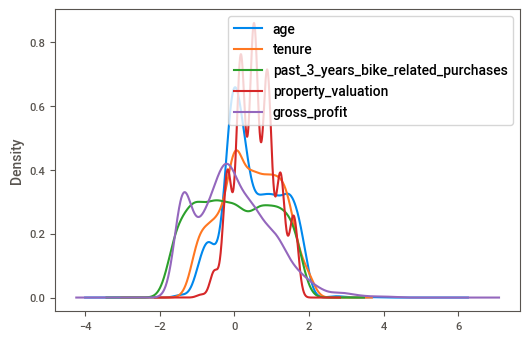

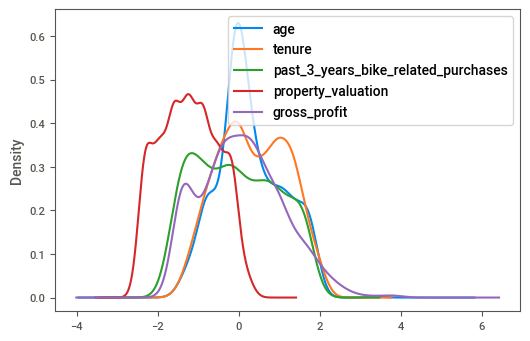

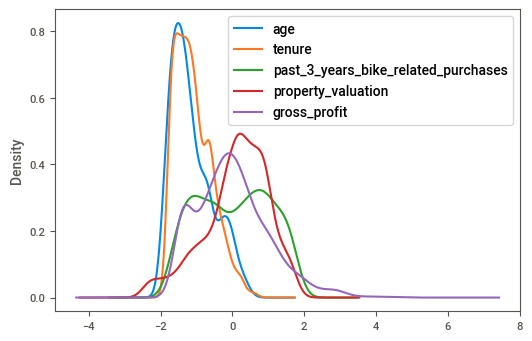

In [ ]:
# numerical vars (use scaled values for easy visualization) for kproto model
num = pd.concat([X1,Cluster],axis=1,ignore_index=False)
num.groupby('kproto_label')[['age','tenure','past_3_years_bike_related_purchases',
                             'property_valuation','gross_profit']].plot(kind='density')

### density distribution for property_valuation, age, tenure are "quite separated" between labels for prototypes model 

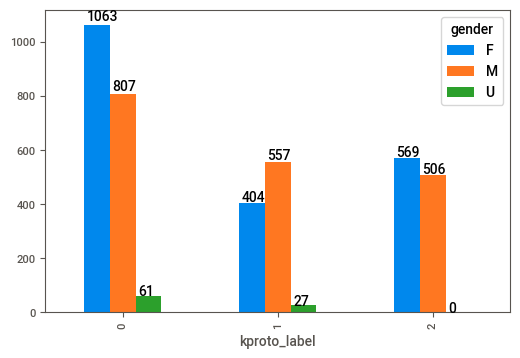

In [ ]:
# check gender distributions between different labels with KPrototypes model
ax = cat.groupby(['gender','kproto_label']).size().unstack('gender').plot.bar()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()*0.1, p.get_height() * 1.015))

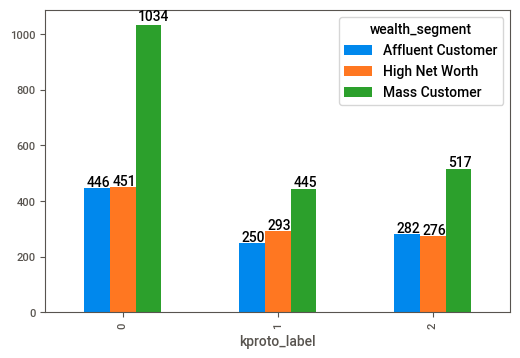

In [ ]:
# check wealth_segment distributions between different labels with KPrototypes model
ax = cat.groupby(['wealth_segment','kproto_label']).size().unstack('wealth_segment').plot.bar()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()*0.1, p.get_height() * 1.015))

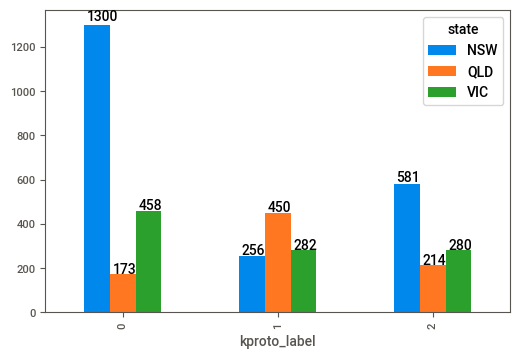

In [ ]:
# check state distributions between different labels with KPrototypes model
ax = cat.groupby(['state','kproto_label']).size().unstack('state').plot.bar()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()*0.1, p.get_height() * 1.015))

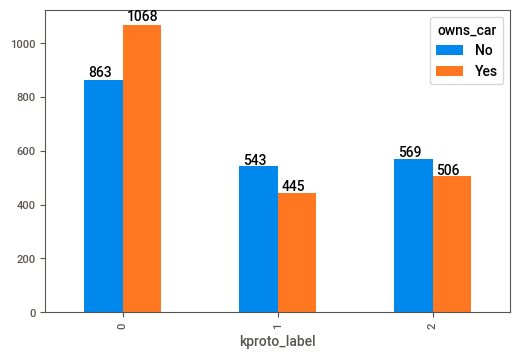

In [ ]:
# check wealth_segment distributions between different labels with KPrototypes model
ax = cat.groupby(['owns_car','kproto_label']).size().unstack('owns_car').plot.bar()

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()*0.1, p.get_height() * 1.015))

# 4. References:
1. https://theforage.com/
2. https://towardsdatascience.com/evaluating-goodness-of-clustering-for-unsupervised-learning-case-ccebcfd1d4f1
3. https://heartbeat.comet.ml/how-to-evaluate-clustering-based-models-in-python-503343816db2
4. https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py
